In [1]:
from IPython.display import display, HTML

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
from torch import nn
import transformers
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from bert_utils import load_tokenizer
from nltk.corpus import stopwords 
from preprocess_utils import preprocess_texts
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import itertools
from bert_embeddings import load_bert_embeddings
from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs
from general_utils import timer
import config as CONFIG
import  gc
import time

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [4]:
np.random.seed(CONFIG.RANDOM_SEED)

In [5]:
torch.manual_seed(CONFIG.RANDOM_SEED)

In [6]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

Notes:
-------
* Reasons a document may not get a context word when sampling
    * IDF thresh
    * Unkown (missing from vocabulary)
    * when tokenized all are word pieces (if not observing word pieces)
    * Contains only stopwords and numbers

Still Working On :
-------------------
* Flip labels for heterogeneous - **done**
* Replace tokens for pos samples - **done**
* Batch size > 2 - **done**
* Iterative training - **done**
* batch prediciton 
* cross val for parameter choosing
* split train for val set 
* freeze bert layer 12 option

Flow :
------

* Dataset Prep
    * Preprocess
    * context word generation
* Bert Embeddings For Clustering
* Clustering
* Picking Cluster Pairs
* For each Cluster Pair :
    * Training
    * Metric Calculation

In [7]:
data_path = "../sampled_articles_from_relevant_data.csv"

In [8]:
# test_b = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

In [9]:
# for name, param in test_b.named_parameters():
#     print(name)

In [10]:
# data_utils

# Need:
# 1) A way to generate vocabulary to sample from
# 2) Sampling Context Words
# 3) Negative Binary Sampling to generate negative labels for the context words

def load_data(file_path):
    """
    """
    tokenizer = load_tokenizer()
    df = pd.read_csv(data_path)
    df.drop(columns=["all_text"],inplace=True)
    df["processed_title"] = preprocess_texts(df["title"].tolist())
    return df
    

def calc_idf(vocab_dict,num_docs = 100000):
    """
    idf_t = log(N/df_t)
    
    Large it is rarer the term, smaller it is more frequent the term
    """
    return {key: np.log2(num_docs/vocab_dict[key]) for key in vocab_dict.keys()}

def filter_vocab(vocab_idf_dict,thresh=10.0,filter_word_pieces=True):
    """
    """
    # remove words from title vocab that have very low idf values and are stopwords
    stop_words = set(stopwords.words("english"))
    vocab_idf = dict(filter(lambda x: x[1]>=thresh, vocab_idf_dict.items()))
    vocab_idf = dict(filter(lambda x: x[0] not in stop_words, vocab_idf.items()))
    vocab_idf = dict(filter(lambda x: "UNK" not in x[0], vocab_idf.items())) # Token absent from bert's vocab
    vocab_idf = dict(filter(lambda x: not x[0].isnumeric(), vocab_idf.items())) # Don't include numbers to represent context words
    vocab_idf = dict(filter(lambda x: len(x[0]) >= 3,vocab_idf.items())) # filter out small words
    
    if filter_word_pieces:
        vocab_idf = dict(filter(lambda x: "##" not in x[0], vocab_idf.items()))
    
    
    
    return vocab_idf

def get_vocab(text_list):
    """
    Here we get the vocab to sample from for obtaining our context word also has idf information
    
    Strategy 1: Using words from the title
    """
    tokens_list = []
    tokenizer = load_tokenizer()
    vocab_df = defaultdict(int)
    for text in text_list:
        token_ids = tokenizer.encode(text,add_special_tokens=False)
        tokens = tokenizer.convert_ids_to_tokens(token_ids)
        
        for token in tokens:
            vocab_df[token] +=1
        
    vocab_idf = calc_idf(vocab_df)
    
    print("Vocab_size : %s" %str(len(vocab_idf.keys())))
    
    return vocab_idf

def replace_context_word(token_text,context_word):
    """
    """
    token_text.remove(context_word)
    
    return token_text

def sample_context_words(text_list,idf_thresh=10.0,pos_sample_num=3,neg_sample_num=3,cword_type="pos",filter_word_pieces=True):
    """
    """
    vocab_idf = get_vocab(text_list)
    vocab_idf = filter_vocab(vocab_idf,
                             thresh=idf_thresh,
                             filter_word_pieces=filter_word_pieces)
    
    print("Vocab Size After Filtering : %s" %str(len(vocab_idf.keys())))
    tokenizer = load_tokenizer()
    
    if cword_type == "pos":
        
        context_words = []
        fails = 0
        for text in text_list :
            context_word = sample_context_words_pos(text,vocab_idf,tokenizer,filter_word_pieces=filter_word_pieces,pos_sample_num=pos_sample_num)
            if "DROP_THIS" in Counter(context_word) and Counter(context_word)["DROP_THIS"] == pos_sample_num:
                fails+=1
            context_words.append(context_word)
        
        print("Failed to find context words for : %s docs" %str(fails))
        return context_words
    
    else:
        
        context_words = []
        fails= 0
        for text in text_list :
            # result is list of lists where list[0] has length = neg_sample_num
            con_wl = sample_context_words_neg(text,vocab_idf,tokenizer,neg_sample_num=neg_sample_num)
            if con_wl == None:
                fails+=1
            context_words.append(con_wl)
            
        print("Failed to find context words for : %s docs" %str(fails))
        return context_words

def sample_context_words_pos(text,vocab_idf,tokenizer,pos_sample_num=3,filter_word_pieces=True):
    """
    Sample from titles vocab but don't include stopwords or low-idf terms (frequent terms)
    """
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text,add_special_tokens=False))
    
    if filter_word_pieces:
        tokens = [t for t in tokens if "#" not in t]
    
    sampled_indices = random.sample(range(len(tokens)),k=len(tokens))
    context_word = None
    loop_counter = 0
    temp_c = 0
    context_words = []
    for indice in sampled_indices:
        if temp_c == pos_sample_num:
            break
        context_word = tokens[sampled_indices[indice]]
        if context_word in vocab_idf:
            context_words.append(context_word)
            context_word = None
            temp_c +=1
            
    # Nones to add:
    nones_to_add = pos_sample_num - len(context_words)
    if nones_to_add > 0:
        context_words += ["DROP_THIS"] * nones_to_add
    
    return context_words


def sample_context_words_neg(text,vocab_idf,tokenizer,neg_sample_num=3):
    """
    Similar to Pos context word sampling 
    
    sample from titles vocab but don't include stopwords or low-idf terms (frequent terms) and not in text
    """
    
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text,add_special_tokens=False))
    
    context_words = None
    hard_stop = 0
    while True:
        context_words = random.sample(list(vocab_idf.keys()),k=neg_sample_num)
        hard_stop += 1
        not_in_vocab = 0
        for c_w in context_words:
            if c_w not in tokens:
                not_in_vocab +=1
        
        if not_in_vocab == neg_sample_num:
            break
        
        if hard_stop == 11:
            context_words = None
            break
    
    return context_words

In [11]:
def batch_text_gen(input_1_list,
                   input_2_list,
                   output_1_list,
                   output_2_list,
                   which_cluster,batch_size=500):
    """
    """
    for ndx in range(0,len(input_1_list),batch_size):
        yield input_1_list[ndx:min(ndx+batch_size,len(input_1_list))], input_2_list[ndx:min(ndx+batch_size,len(input_2_list))], output_1_list[ndx:min(ndx+batch_size,len(output_1_list))], output_2_list[ndx:min(ndx+batch_size,len(output_2_list))], which_cluster[ndx:min(ndx+batch_size,len(which_cluster))]

def batch_gen_pred(x1_tensor,x2_tensor,y1_tensor,y2_tensor,batch_size):
    """
    """

    for ndx in range(0,list(x1_tensor.size())[0],batch_size):
        yield x1_tensor[ndx:min(ndx+batch_size,list(x1_tensor.size())[0]),:],  x2_tensor[ndx:min(ndx+batch_size,list(x2_tensor.size())[0]),:], y1_tensor[ndx:min(ndx+batch_size,list(y1_tensor.size())[0])], y2_tensor[ndx:min(ndx+batch_size,list(y2_tensor.size())[0])]

def tokenize_4bert_batch(input1,input2,output1,output2,tokenizer):
    """
    """
    cuda1 = torch.device('cuda:1')
    
    input_1_cor = []
    
    for a,b in zip(input1,input2):
        input_1_cor.append(a.replace(b,""))
    
    
    tokenized_tensor = torch.LongTensor([tokenizer.encode(text,
                                                          truncation=True,
                                                          padding="max_length",
                                                          max_length=500, 
                                                          add_special_tokens=True)
                                                          for text in input_1_cor])
    
    tokenized_context_word = torch.LongTensor([tokenizer.encode(word,truncation=True,add_special_tokens=False,max_length=1) for word in input2])
    
    class_labels = torch.FloatTensor(output1)
    word_labels = torch.FloatTensor(output2)
    
    tokenized_tensor = tokenized_tensor.to(cuda1)
    tokenized_context_word = tokenized_context_word.to(cuda1)
    class_labels = class_labels.to(cuda1)
    word_labels = word_labels.to(cuda1)
    
    return tokenized_tensor, tokenized_context_word, class_labels, word_labels


# Model

class AttentionMT(nn.Module):
    
    def __init__(self,embedding_size=768,verbose=True,bert_train=False):
        super(AttentionMT,self).__init__()
        
        cuda1 = torch.device('cuda:1')
        self.verbose = verbose
        self.bert_train = bert_train
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.bert.to(cuda1)
        if self.bert_train:
            # Set the pre-trained model in training mode (for Fine Tuning)
            self.bert.train()
        if not self.bert_train:
            # Set the pre-trained model in evaluation mode (for inference only)
            self.bert.eval()
        
        self.attention = nn.Linear(in_features=embedding_size,
                                   out_features=1,
                                   bias=False)
        
        # Recommendation Network
        # ------------------------
        
        self.recom_pred = nn.Linear(in_features=embedding_size,
                                    out_features=1,
                                    bias=True)
        
        # Softmax Activation
        self.softmax = nn.Softmax(dim=-1)
        
        # Sigmoid Activation
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,bert_tokenized_words,bert_tokenized_word_to_predict):
        """
        """
#         return self.forward_single(bert_tokenized_words,bert_tokenized_word_to_predict)
        return self.forward_batch(bert_tokenized_words,bert_tokenized_word_to_predict)
        
    def forward_single(self,
                bert_tokenized_words,
                bert_tokenized_word_to_predict):
        """
        Inputs:
        ------
        
        Outputs:
        --------
        """
        
        # ************ Recommendation Network ********************
        
        # output shape should be (max_length,dim)
        bert_output = self.bert(input_ids=bert_tokenized_words)
        bert_hidden_states  = bert_output[2]
        bert_layer12_hidden_states = bert_hidden_states[-1][0,:,:]

        attention_un = torch.cat([self.attention(embedding) for embedding in bert_layer12_hidden_states])  # shape (N,max_length,1) *** u_it **
        attentions = self.softmax(attention_un) # shape (N,max_length,1) ***  a_it ***
        attention_cvector = bert_layer12_hidden_states.T.mul(attentions).sum(dim=1) # shape (N,768,1) *** s_i ***
        y_pred = self.sigmoid(self.recom_pred(attention_cvector.T))
        
        # ************** Word Prediction Network ********************
        context_word_embed_bert = self.bert(input_ids=bert_tokenized_word_to_predict)
        context_word_embed_bert_hs = context_word_embed_bert[2]
        context_word_embed_bert_layer_12 = context_word_embed_bert_hs[-1][0,:,:]
        
        context_pred = self.sigmoid(torch.mul(attention_cvector,context_word_embed_bert_layer_12).sum(dim=1))
        
        if self.verbose:
            print("\nShape Details :")
            print("1. Bert Embeddings Shape : %s" %str(bert_layer12_hidden_states.size()))
            print("2. attention_un Shape : %s" %str(attention_un.size()))
            print("3. attention_norm Shape : %s" %str(attentions.size()))
            print("4. attention_cvector shape : %s" %str(attention_cvector.size()))
            print("5. y_pred shape : %s" %str(y_pred.size()))
            print(str(y_pred.item()))
            print("6. context_word_embed_bert shape : %s" %str(context_word_embed_bert_layer_12.size()))
            print("7. context_pred shape : %s" %str(context_pred.size()))
            print(str(context_pred.item()))
        
        return y_pred, context_pred, attention_cvector
    
    def forward_batch(self,
                      bert_tokenized_words_batch,
                      bert_tokenized_word_to_predict_batch):
        """
        Shape Details :
        
        when considering single samples
        1. Bert Embeddings Shape : torch.Size([500, 768])
        2. attention_un Shape : torch.Size([500])
        3. attention_norm Shape : torch.Size([500])
        4. attention_cvector shape : torch.Size([768])
        5. y_pred shape : torch.Size([1])
        0.5326072573661804
        6. context_word_embed_bert shape : torch.Size([1, 768])
        7. context_pred shape : torch.Size([1])
        
        when considering batches
        1. Bert Embeddings Shape : (N,500,768)-> Done
        2. attention_un Shape : (N,500)
        3. attention_norm Shape : (N,500)
        4. attention_cvector Shape : (N,768)
        5. ypred Shape : (N,1)
        6. context_word_embed_bert shape : torch.Size([N, 768])
        7. context_pred shape : torch.Size([N,1])
        
        """
        
        # ************* REC NETWORK *********************
        
        bert_output = self.bert(input_ids=bert_tokenized_words_batch)
        bert_hidden_states  = bert_output[2]
        bert_layer12_hidden_states = bert_hidden_states[-1]
        
        # Unormalized Word Attentions
        atten_un_batch = []
        for item_in_batch in range(bert_layer12_hidden_states.size(0)):
            atten_un_sent = []
            for word_in_sent in range(bert_layer12_hidden_states.size(1)):
                word_atten_un = self.attention(bert_layer12_hidden_states[item_in_batch,word_in_sent,:]).unsqueeze(0) # should be of size [1,1]
                atten_un_sent.append(word_atten_un)  
            
            atten_un_sent = torch.cat(atten_un_sent,dim=0).T # should have shape (1,500)
            atten_un_batch.append(atten_un_sent)
        
        atten_un_batch = torch.cat(atten_un_batch,dim=0) # should have shape (N,500)
        
        
#         atten_un_batch = self.attention(bert_layer12_hidden_states) # should have shape (N,500,1)
#         print("Unormalized Attention Shape : %s" %str(atten_un_batch.size()))
        
        
        # Normalized Word Attentions
        attentions_norm_batch = self.softmax(atten_un_batch).squeeze(-1) # should have shape (N,500) or (N,500,1)
#         print("Normalized Attention Shape : %s"%str(attentions_norm_batch.size()))
        
        # Sentence Context vector
        attention_cvector_batch = []
        
        for item_in_batch in range(bert_layer12_hidden_states.size(0)):
            attention_cvector = bert_layer12_hidden_states[item_in_batch,:,:].T.mul(attentions_norm_batch[item_in_batch,:]).sum(dim=1) # shape (1,768)
            attention_cvector_batch.append(attention_cvector.unsqueeze(0)) 
        
        
        attention_cvector_batch = torch.cat(attention_cvector_batch,dim=0) # shape (N,768) *** s_i ***
#         print("Sentence context vector shape : %s" %str(attention_cvector_batch.size()))
        
        # Output Layer 1
        y_pred = self.sigmoid(self.recom_pred(attention_cvector_batch)).squeeze() # shape (N,1)
#         print("Output Layer 1 Shape : %s" %str(y_pred.shape))
        # **************** WORD PRED NETWORK ****************   
        context_word_embed_bert = self.bert(input_ids=bert_tokenized_word_to_predict_batch)
        context_word_embed_bert_hs = context_word_embed_bert[2]
        context_word_embed_bert_layer_12 = context_word_embed_bert_hs[-1] # shape (N,1,768)
        
        attention_wcprod_batch = []
        for item_in_batch in range(context_word_embed_bert_layer_12.size(0)):
            
            attention_wc_prod = torch.mul(attention_cvector_batch[item_in_batch,:],
                                          context_word_embed_bert_layer_12[item_in_batch,:,:]).sum(dim=1) # shape (1,1)
            attention_wcprod_batch.append(attention_wc_prod)
        
        attention_wcprod_batch = torch.cat(attention_wcprod_batch,dim=0) # shape (N,1)
#         print("Attention Word Context Product : %s" %str(attention_wcprod_batch.size()))
        context_pred = self.sigmoid(attention_wcprod_batch) # shape (N,1)
#         print("Output Layer 2 Shape : %s" %str(context_pred.size()))
    
        return y_pred, context_pred, attention_cvector_batch

def reset_weights(m):
    """
    Try resetting model weights to avoid
    weight leakage.
    """
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print("Reset trainable parameters of layer : %s"%str(layer))
            layer.reset_parameters()

In [12]:
# Clustering utils

def get_cluster_pairs_top(df,vectors,sample_size=3):
    """
    """
    # Now drop the rows with Nones for context_word_pos and similarly do the same to the embeddings
    
    df["drop_"] = df['context_word_pos'].apply(lambda x: x == ["DROP_THIS"]*sample_size)
    
    indices_to_drop = df.index[df['drop_'] == True].tolist()
    print("Indices to drop : %s" %str(len(indices_to_drop)))
    clean_df = df.drop(df.index[indices_to_drop])
    clean_df.reset_index(drop=True,inplace=True)
    print(clean_df.head(2))
    print("New Df Shape : %s" %str(clean_df.shape))
    
    vectors = np.delete(vectors,indices_to_drop,axis=0)
    
    clusters,cluster_clf = run_clustering(vectors=vectors,
                                              seed=CONFIG.RANDOM_SEED,
                                              num_clusters=CONFIG.num_clusters,
                                              clus_type="kmeans")
    
    doc_2_cluster_map = cluster2doc(num_texts= clean_df.shape[0],
                                    cluster_labels=cluster_clf.labels_)
    
    
    cluster_sizes = get_cluster_sizes(cluster_clf)
    
    cluster_pairs = get_cluster_pairs(num_clusters=CONFIG.num_clusters)
    
    filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                            doc_2_cluster_map=doc_2_cluster_map,
                                            cluster_sizes=cluster_sizes,
                                            partisan_scores=clean_df["binary_ps"].tolist(),
                                            min_size=CONFIG.min_cluster_size,
                                            max_size=CONFIG.max_cluster_size,
                                            min_partisan_size=CONFIG.min_partisan_size)
    
    top100 = None
    
    if len(filtered_cluster_pairs) > 100:
        print("\nNumber of Filtered Cluster Pairs are greater 100, picking top 100 most similar cluster pairs")
        cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")
        top100 = get_top_100_clusterpairs(cluster_pairs=filtered_cluster_pairs,dist_matrix=cluster_pair_dist_mat,reverse=True)
        
    else:
        top100 = filtered_cluster_pairs
        print("\nNumber of Filtered Cluster Pairs is less than 100 so skipping top 100 selection")
    
    return clean_df , doc_2_cluster_map, top100 

def get_label_dist(df,columns=["class_label","word_label"]):
    """
    """
    for c in columns:
        print("%s dist :\n"%c)
        print(df[c].value_counts())

def get_train_test_ssda(df,cp,doc_2_cluster_map,neg_sample_size=3):
    """
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, test of cluster 1 test size
    """
    c1_df, c2_df = get_train_test_attm(df,cp,doc_2_cluster_map,neg_sample_size=neg_sample_size)
    c1_df["which_cluster"] = [1]*c1_df.shape[0]
    c2_df["which_cluster"] = [2]*c2_df.shape[0]
    
    c1_train, c1_test = train_test_split(c1_df,test_size=0.30, random_state=CONFIG.RANDOM_SEED)
    
    c1_train_num = c1_train.shape[0]
    
    c2_df_train,c2_df_test = train_test_split(c2_df,train_size=int(0.1*c1_train_num), random_state=CONFIG.RANDOM_SEED)
    
    print("\nSample size from C1 in Train : %s" %str(c1_train.shape))
    get_label_dist(c1_train)
    print("\nSample size from C2 in Train : %s" %str(c2_df_train.shape))
    get_label_dist(c2_df_train)
    
    train = pd.concat([c1_train,c2_df_train],axis=0)
    print("\nTrain Size : %s"%str(train.shape))
    get_label_dist(train)
    
    c2_test_,_ = train_test_split(c2_df_test,train_size=c1_test.shape[0], random_state=CONFIG.RANDOM_SEED)
    
    print("\nSample Size from C1 in Test : %s" %str(c1_test.shape))
    get_label_dist(c1_test)
    print("\nSample Size from C2 in Test : %s" %str(c2_test_.shape))
    get_label_dist(c2_test_)
    
    test = pd.concat([c1_test,c2_test_],axis=0)
    print("\nTest Size : %s" %str(test.shape))
    get_label_dist(test)
    
    train = train.sample(frac=1.0,random_state=CONFIG.RANDOM_SEED)
    test = test.sample(frac=1.0,random_state=CONFIG.RANDOM_SEED)
    
    return train,test



def mask_arrays(yp_1,yp_2,y1,y2,which_cluster,cluster_2_mask=1):
    """
    """
    yp_1_ma = []
    yp_2_ma = []
    y1_ma = []
    y2_ma = []
    
    for wc_i , cluster in enumerate(which_cluster):
        if cluster != cluster_2_mask:
            yp_1_ma.append(yp_1[wc_i])
            yp_2_ma.append(yp_2[wc_i])
            y1_ma.append(y1[wc_i])
            y2_ma.append(y2[wc_i])
    
    return yp_1_ma, yp_2_ma, y1_ma, y2_ma
            

def calc_score_(yp_1,yp_2,y1,y2,scores_,key="overall"):
    """
    """
    yp_1 = np.array(yp_1,d)
    yp_2 = np.array(yp_2)
    y1 = np.array(y1)
    y2 = np.array(y2)
     
    
    yp_1[yp_1 > 0.5] = 1.0
    yp_1[yp_1 <= 0.5] = 0.0
    yp_2[yp_2 > 0.5] = 1.0
    yp_2[yp_2 <=0.5] = 0.0
    
    if 0.0 not in yp_1 or 1.0 not in yp_1:
        print("One class predicitions for class labels")
    
    if 0.0 not in yp_2 or 1.0 not in yp_2: 
        print("One class predictions for word labels")
    
    f1 = metrics.f1_score(y1,yp_1,average="macro")
    prec = metrics.precision_score(y1,yp_1,average="macro")
    recall = metrics.recall_score(y1,yp_1,average="macro")
    try:
        roc_auc = metrics.roc_auc_score(y1,yp_1,average="macro")
    except:
        print("ROC Error")
        roc_auc = 0.0
    accuracy = metrics.accuracy_score(y1,yp_1)
    
    scores_[key]["class_scores"]["f1"] = f1
    scores_[key]["class_scores"]["precision"] = prec
    scores_[key]["class_scores"]["recall"] = recall
    scores_[key]["class_scores"]["accuracy"] = roc_auc
    scores_[key]["class_scores"]["roc_auc"] = accuracy
    
    f1 = metrics.f1_score(y2,yp_2,average="macro")
    prec = metrics.precision_score(y2,yp_2,average="macro")
    recall = metrics.recall_score(y2,yp_2,average="macro")
    try:
        roc_auc = metrics.roc_auc_score(y2,yp_2,average="macro")
    except:
        print("ROC Error")
        roc_auc = 0.0
    accuracy = metrics.accuracy_score(y2,yp_2)
    
    scores_[key]["word_scores"]["f1"] = f1
    scores_[key]["word_scores"]["precision"] = prec
    scores_[key]["word_scores"]["recall"] = recall
    scores_[key]["word_scores"]["accuracy"] = roc_auc
    scores_[key]["word_scores"]["roc_auc"] = accuracy
    
    return scores_
    

def calculate_scores(preds_1,preds_2,true_1,true_2,which_cluster):
    """
    """
    scores_ = defaultdict(lambda : defaultdict(lambda : defaultdict(float)))
    # overall_metrics
    scores_ = calc_score_(preds_1,preds_2,true_1,true_2,scores_,key="overall")
    
    # cluster 1 metrics
    yp_1_ma, yp_2_ma, y1_ma, y2_ma =  mask_arrays(preds_1,preds_2,true_1,true_2,which_cluster,cluster_2_mask=2)
    scores_ = calc_score_(yp_1_ma,yp_2_ma,y1_ma,y2_ma,scores_,key="cluster1")
    
    # cluster 2 metrics
    yp_1_ma, yp_2_ma, y1_ma, y2_ma =  mask_arrays(preds_1,preds_2,true_1,true_2,which_cluster,cluster_2_mask=1)
    scores_ = calc_score_(yp_1_ma,yp_2_ma,y1_ma,y2_ma,scores_,key="cluster2")
    
    return scores_

@timer
def batch_predict_and_score(model,data,batch_size = 25):
    """
    """
    articles = data["text"].tolist()
    context_words = data["context_word"].tolist()
    class_labels = data["class_label"].tolist()
    word_labels = data["word_label"].tolist()
    which_cluster = data["which_cluster"].tolist()
    bert_tokenizer = load_tokenizer()
    batch_rec_preds = []
    batch_context_preds = []
    for batch_num, (article_batch, context_word_batch, class_label_batch, word_label_batch, which_cluster_batch) in enumerate(batch_text_gen(articles,
                                                                                                                                                 context_words,
                                                                                                                                                 class_labels,
                                                                                                                                                 word_labels,
                                                                                                                                                 which_cluster,
                                                                                                                                                 batch_size=batch_size)):
            
            bert_tokenized_words, bert_tokenized_word_to_predict, rec_labels, word_labels_ = tokenize_4bert_batch(article_batch,
                                                                                                                 context_word_batch, 
                                                                                                                 class_label_batch, 
                                                                                                                 word_label_batch, tokenizer=bert_tokenizer)
            with torch.no_grad():
                y_pred, context_pred, attention_vector = model(bert_tokenized_words, bert_tokenized_word_to_predict)
                
                batch_rec_preds.append(y_pred.cpu().numpy())
                batch_context_preds.append(context_pred.cpu().numpy())
            
            bert_tokenized_words = None
            bert_tokenized_word_to_predict = None
            rec_labels = None
            word_labels_ = None
            
            del bert_tokenized_words
            del bert_tokenized_word_to_predict
            del rec_labels
            del word_labels_
            
            gc.collect()
            torch.cuda.empty_cache()
    
    batch_rec_preds = np.concatenate(batch_rec_preds,axis=0)
    batch_context_preds = np.concatenate(batch_context_preds,axis=0)
    
    scores_ = calculate_scores(batch_rec_preds,batch_context_preds,class_labels,word_labels,which_cluster)
    
    return scores_
                
            

@timer
def train_ssda(data,lr,word_loss_w,epochs=2,batch_size=8):
    """
    """
    cuda1 = torch.device('cuda:1')
    model = AttentionMT(embedding_size=768,verbose=True)
    model.to(cuda1)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    
    bert_tokenizer = load_tokenizer()
    
    epoch_losses = defaultdict(lambda : defaultdict(list))
    
    articles = data["text"].tolist()
    context_words = data["context_word"].tolist()
    class_labels = data["class_label"].tolist()
    word_labels = data["word_label"].tolist()
    which_cluster = data["which_cluster"].tolist()
    
    for epoch in range(epochs):
        
        batch_nums = data.shape[0]/batch_size
        batch_total_loss = []
        batch_word_loss = []
        batch_rs_loss = []
        
        for batch_num, (article_batch, context_word_batch, class_label_batch, word_label_batch, which_cluster_batch) in enumerate(batch_text_gen(articles,
                                                                                                                                                 context_words,
                                                                                                                                                 class_labels,
                                                                                                                                                 word_labels,
                                                                                                                                                 which_cluster,
                                                                                                                                                 batch_size=batch_size)):
            
            bert_tokenized_words, bert_tokenized_word_to_predict, rec_labels, word_labels_ = tokenize_4bert_batch(article_batch,
                                                                                                                 context_word_batch, 
                                                                                                                 class_label_batch, 
                                                                                                                 word_label_batch, tokenizer=bert_tokenizer)
            opt.zero_grad() # reset all the gradient information
    
            y_pred, context_pred, attention_vector = model(bert_tokenized_words, bert_tokenized_word_to_predict)
            
            
            if y_pred.size() != rec_labels.size():
                rec_labels = rec_labels.squeeze(0)
            
            if context_pred.size() != word_labels_.size():
                context_pred = context_pred.squeeze(0)
            
            rec_loss = loss_func(y_pred,rec_labels)
            word_loss = loss_func(context_pred,word_labels_)
            
            total_loss = rec_loss + (word_loss_w * word_loss)
            
            total_loss.backward()
            
            opt.step()
            
            batch_rs_loss.append(rec_loss.item())
            batch_word_loss.append(word_loss.item())
            batch_total_loss.append(total_loss.item())
            
            if batch_num % 100 == 0 and batch_num >=100:
                print("Epoch : %s | Batch : %s | Total Loss : %s | Rec Loss : %s | Word Loss : %s" % (str(epoch),str(batch_num),str(total_loss.item()),str(rec_loss.item()),str(word_loss.item())))
            
            
        epoch_losses[epoch]["rs_loss"].append(batch_rs_loss)
        epoch_losses[epoch]["word_loss"].append(batch_word_loss)
        epoch_losses[epoch]["total_loss"].append(batch_total_loss)
        
        scores_train =  batch_predict_and_score(model,data,batch_size = 25)
    
    bert_tokenized_words = None
    bert_tokenized_word_to_predict = None
    rec_labels = None
    word_labels_ = None
    rec_loss = None
    total_loss = None
    word_loss = None
    opt = None
    

    del bert_tokenized_words
    del bert_tokenized_word_to_predict
    del rec_labels
    del word_labels_
    del opt
    del total_loss
    del rec_loss
    del word_loss

    gc.collect()
    torch.cuda.empty_cache()
    
    return model, epoch_losses, scores_train
    
    

def test_ssda(model,data,batch_size=25):
    """
    """
    scores_ = batch_predict_and_score(model,data,batch_size = batch_size)
    return scores_


def run_ssda(df,cp,doc_2_cluster_map,learning_rates=[0.0001,0.001,0.01,0.1],epochs=3,word_pred_loss_weights=[0.3,0.8],batch_size=8,neg_sample_size=3):
    """
    Uses a self supervised domain adaptation setting to train the model
    
    * train = 90% c1 data + 10% c2 data
    * test = 50% c1 data + 50% c2 data
    
    * From cluster 1 choose 70% of the data for train, 30% for test
    * From cluster 2 choose 10% of 70% from c1 for train, 
    
    * Loss check
    * Metrics = F1, recall, precision, accuracy, roc
    """
    train, test = get_train_test_ssda(df,cp,doc_2_cluster_map,neg_sample_size=neg_sample_size)
    metrics_train = defaultdict()
    metrics_test = defaultdict()
    losses_train = defaultdict()
    # train ssda func
    for lr in learning_rates:
        for word_loss_w in word_pred_loss_weights:
            
            # FREE MEMORY
            model = None
            del model
            gc.collect()
            torch.cuda.empty_cache()
            
            print("sleeping for 10")
            time.sleep(10)
            
            model, losses_train , scores_train = train_ssda(train,lr,word_loss_w,epochs=epochs,batch_size=batch_size)
            scores_test = test_ssda(model,test)
            metrics_train[(lr,word_loss_w)] = scores_train
            metrics_test[(lr,word_loss_w)] = scores_test
            losses_train[(lr,word_loss_w)] = losses_train
            
    return metrics_train,metrics_test, losses_train

def run_ssda_all(df,cps,doc_2_cluster_map,learning_rates=[0.0001,0.001,0.01,0.1],epochs=3,word_pred_loss_weights=[0.3,0.8],batch_size=8,neg_sample_size=3):
    """
    """
    cp_test_scores = defaultdict()
    cp_train_scores = defaultdict()
    cp_train_losses = defaultdict()
    
    for cp in cps:
        metrics_train,metrics_test, losses_train = run_ssda(df,
                                                            cp,
                                                            doc_2_cluster_map,
                                                            learning_rates=learning_rates,
                                                            epochs=epochs,
                                                            word_pred_loss_weights=word_pred_loss_weights,
                                                            batch_size=batch_size,
                                                            neg_sample_size=neg_sample_size)
        
        cp_test_scores[cp] = metrics_test
        cp_train_scores[cp] = metrics_train
        cp_train_losses[cp] = losses_train
    
    return cp_test_scores, cp_train_scores, cp_train_losses
    

def gen_samples(df,neg_sample_size=3):
    """
    columns = processed_text,processed_title, context_word_pos, context_word_neg
    """
    
    df["processed_all"] = df["processed_title"] + " " + df["processed_text"]
    
    text_list = df["processed_all"].tolist()
    ps_labels = df["binary_ps"].tolist()
    pos_con_word = df["context_word_pos"].tolist()
    neg_con_word = df["context_word_neg"].tolist()
    
    text_list_neg = []
    ps_labels_neg = []
    text_list_pos = []
    ps_labels_pos = []
    
    for ind_t, text in enumerate(text_list):
        text_list_neg.append([text]*neg_sample_size)
        ps_labels_neg.append([ps_labels[ind_t]]*neg_sample_size)
        text_list_pos.append([text]*neg_sample_size)
        ps_labels_pos.append([ps_labels[ind_t]]*neg_sample_size)
        
    text_list_neg = list(itertools.chain(*text_list_neg))
    neg_con_word = list(itertools.chain(*neg_con_word))
    ps_labels_neg = list(itertools.chain(*ps_labels_neg))
    
    text_list_pos = list(itertools.chain(*text_list_pos))
    pos_con_word = list(itertools.chain(*pos_con_word))
    ps_labels_pos = list(itertools.chain(*ps_labels_pos))
    
    assert len(text_list_neg) == len(neg_con_word)
    assert len(text_list_neg) == len(text_list_pos)
    assert len(text_list_pos) == len(pos_con_word)
    
    all_text_list = text_list_pos + text_list_neg
    all_con_word = pos_con_word + neg_con_word
    all_word_labels = ([1]*len(pos_con_word)) + ([0] * len(neg_con_word))
    all_ps_labels = ps_labels_pos + ps_labels_neg
    
    df_sample = pd.DataFrame()
    df_sample["text"] = all_text_list
    df_sample["context_word"] = all_con_word
    df_sample["word_label"] = all_word_labels
    df_sample["class_label"] = all_ps_labels
    
    df_sample = df_sample.loc[df_sample["context_word"] != "DROP_THIS"].reset_index(drop=True)
    
    # Shuffle twice
    df_sample = df_sample.sample(frac=1.0,random_state=CONFIG.RANDOM_SEED)
    df_sample = df_sample.sample(frac=1.0,random_state=CONFIG.RANDOM_SEED+1)
    
    return df_sample
    
    

def get_train_test_attm(df,cp,doc_2_cluster_map,neg_sample_size=3):
    """
    train and test we need to first subsample using doc_2_cluster_map for each cluster
    get train and test , then create negative samples and finally shuffle both train and test
    """
    cluster1_indices = doc_2_cluster_map[cp[0]]
    cluster2_indices = doc_2_cluster_map[cp[1]]
    
    train_df = df.iloc[cluster1_indices].reset_index(drop=True)
    test_df = df.iloc[cluster2_indices].reset_index(drop=True)
    
    print("Original Train Shape : %s" %str(train_df.shape))
    print("Original Test Shape : %s" %str(test_df.shape))
    
    train_df = gen_samples(train_df,neg_sample_size=neg_sample_size)
    test_df = gen_samples(test_df,neg_sample_size=neg_sample_size)
    
#     print("Original class_labels : \n%s" %str(test_df["class_label"].iloc[:10]))
    
    test_df["class_label"] = test_df["class_label"].apply(lambda x: np.abs(x+(-1)))
    
#     print("Flipped class_labels : \n%s" %str(test_df["class_label"].iloc[:10]))
    
    train_df = train_df.sample(frac=1,random_state=CONFIG.RANDOM_SEED).reset_index(drop=True)
    test_df = test_df.sample(frac=1,random_state=CONFIG.RANDOM_SEED).reset_index(drop=True)
    
    print("Exploded Train Shape : %s" %str(train_df.shape))
    print("Exploded Test Shape : %s" %str(test_df.shape))
    return train_df,test_df
    

def partial_train_step(x1,x2,rec_label,word_label,model,opt,loss_func,context_pred_loss_weight=0.5):
    """
    """
    opt.zero_grad()
    y_pred, context_pred, attention_vector = model(x1, x2)
    rec_loss = loss_func(y_pred,rec_label)
    word_loss = loss_func(context_pred,word_label)
    total_loss = rec_loss + (context_pred_loss_weight * word_loss)
    total_loss.backward()
    opt.step()
    
    return y_pred, context_pred, attention_vector, rec_loss, word_loss, total_loss

def plot_epoch_loss(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
    ax.plot(range(len(epoch_losses[0]["total_loss"][0])),epoch_losses[0]["total_loss"][0],c="green",label="Total Loss")
    ax.plot(range(len(epoch_losses[0]["word_loss"][0])),epoch_losses[0]["word_loss"][0],c="blue",label="Word Loss")
    ax.plot(range(len(epoch_losses[0]["rs_loss"][0])),epoch_losses[0]["rs_loss"][0],c="red",label="RS Loss")
    ax.set_xlabel("Batch Num")
    ax.set_ylabel("Training Loss")
    ax.set_title("Training Loss for ATMT")
    plt.legend()
    plt.show()

In [13]:
# mocking baseline 2

@timer
def run_cp(df,cp,doc_2_cluster_map,learning_rate,context_pred_loss_weight,num_epochs,batch_size,increments=10):
    """
    """
    train,test = get_train_test_attm(df,cp,doc_2_cluster_map)
        
    model, epoch_losses, opt, loss_func = train_model(train,
                                                      learning_rate=learning_rate,
                                                      context_pred_loss_weight=context_pred_loss_weight,
                                                      num_epochs=num_epochs,
                                                      batch_size=batch_size)
        
    inc_losses_test,precisions,recalls = incremental_train(model=model,
                                      data=test,
                                      opt=opt,
                                      loss_func=loss_func,
                                      context_pred_loss_weight=context_pred_loss_weight,
                                      increments=increments)
    
    return epoch_losses,inc_losses_test, precisions, recalls

@timer
def run_all_cps(df,cps,doc_2_cluster_map,learning_rate=0.01,context_pred_loss_weight=0.5,num_epochs=2,batch_size=1,increments=10):
    """
    """
    cp_scores = defaultdict(lambda : defaultdict(list))
    epoch_train_loss_cps = defaultdict()
    inc_test_loss_cps = defaultdict()
    
    for cp in cps:
        print("cluster_pair : %s" %str(cp))
        
        epoch_losses,inc_losses_test,precisions, recalls = run_cp(df,cp,doc_2_cluster_map,learning_rate,context_pred_loss_weight,num_epochs,batch_size,increments=increments)
        epoch_train_loss_cps[cp]= epoch_losses
        inc_test_loss_cps[cp] = inc_losses_test
        cp_scores[cp]["precision"] = precisions
        cp_scores[cp]["recall"] = recalls
    
    return epoch_train_loss_cps, inc_test_loss_cps, cp_scores

@timer
def train_model(data,learning_rate=0.01,context_pred_loss_weight=0.5,num_epochs=2,batch_size=1):
    """
    """
    cuda1 = torch.device('cuda:1')
    model = AttentionMT(embedding_size=768,verbose=True)
    model.to(cuda1)
    loss_func = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(),lr=learning_rate)
    
    bert_tokenizer = load_tokenizer()
    
    epoch_losses = defaultdict(lambda : defaultdict(list))
    
    for epoch in range(num_epochs):
        
        batch_nums = data.shape[0]/batch_size
        batch_total_loss = []
        batch_word_loss = []
        batch_rs_loss = []
        
        articles = data["text"].tolist()
        context_words = data["context_word"].tolist()
        class_labels = data["class_label"].tolist()
        word_labels = data["word_label"].tolist()
        which_cluster = data["which_cluster"].tolist()
        
        for batch_num, (article_batch, context_word_batch, class_label_batch, word_label_batch, which_cluster_batch) in enumerate(batch_text_gen(articles,
                                                                                                                                                 context_words,
                                                                                                                                                 class_labels,
                                                                                                                                                 word_labels,
                                                                                                                                                 which_cluster,
                                                                                                                                                 batch_size=batch_size)):
            
            bert_tokenized_words, bert_tokenized_word_to_predict, rec_labels, word_labels = tokenize_4bert_batch(article_batch,
                                                                                                                 context_word_batch, 
                                                                                                                 class_label_batch, 
                                                                                                                 word_label_batch, tokenizer=bert_tokenizer)
            opt.zero_grad() # reset all the gradient information
    
            y_pred, context_pred, attention_vector = model(bert_tokenized_words, bert_tokenized_word_to_predict)
            
            rec_loss = loss_func(y_pred,rec_labels)
            word_loss = loss_func(context_pred,word_labels)
            
            total_loss = rec_loss + (context_pred_loss_weight * word_loss)
            
            total_loss.backward()
            
            opt.step()
            
            batch_rs_loss.append(rec_loss.item())
            batch_word_loss.append(word_loss.item())
            batch_total_loss.append(total_loss)
            
            if batch_num % 100 == 0 and batch_num >=100:
                print("Epoch : %s | Batch : %s | Total Loss : %s | Rec Loss : %s | Word Loss : %s" % (str(epoch),str(batch_num),str(total_loss.item()),str(rec_loss.item()),str(word_loss.item())))
            
            
        epoch_losses[epoch]["rs_loss"].append(batch_rs_loss)
        epoch_losses[epoch]["word_loss"].append(batch_word_loss)
        epoch_losses[epoch]["total_loss"].append(batch_total_loss)
    
    return model, epoch_losses, opt, loss_func

@timer
def incremental_train(model,data,opt,loss_func,context_pred_loss_weight=0.5,increments=100,pred_batch_size=100):
    """
    * we train with one sample
    * recommend from the rest of the candidate pool
    * record recommendation
    * remove recommendation from candidate pool
    * use this recommendation to train again
    * repeat for n increments
    """
    
    articles = data["text"].tolist()
    context_words = data["context_word"].tolist()
    class_labels = data["class_label"].tolist()
    word_labels = data["word_label"].tolist()
        
    bert_tokenizer = load_tokenizer()
    
    bert_tokenized_words, bert_tokenized_word_to_predict, rec_labels, word_labels = tokenize_4bert_batch(articles,
                                                                                                         context_words, 
                                                                                                         class_labels, 
                                                                                                         word_labels, 
                                                                                                         tokenizer=bert_tokenizer)
    candidate_x1 = bert_tokenized_words
    candidate_x2 = bert_tokenized_word_to_predict
    candidate_y1 = rec_labels
    candidate_y2 = word_labels
    
    y1_preds = []
    y2_preds = []
    all_relevant = sum(class_labels)
    precisions_k = []
    recalls_k = []
    
    ttl = []
    rsl = []
    cwl = []
    
    for i in range(increments):
        print("Iter : %s" %str(i))
        predicted_probas_y1 = []
        predicted_probas_y2 = []
        attention_vectors = []
        with torch.no_grad(): # eval or recommendation mode
#             for i in range(candidate_x1.size(0)):
#                 pp_y1, pp_y2, at = model(candidate_x1[i,:].unsqueeze(0),candidate_x2[i,:].unsqueeze(0))
#                 predicted_probas_y1.append(pp_y1.unsqueeze(0))
#                 predicted_probas_y2.append(pp_y2.unsqueeze(0))
#                 attention_vectors.append(at)
            
            for batch_num, (cp_x1_batch, cp_x2_batch, y1_batch, y2_batch) in enumerate(batch_gen_pred(candidate_x1,candidate_x2,candidate_y1,candidate_y2,batch_size=100)):
                pp_y1, pp_y2, at = model(cp_x1_batch,cp_x2_batch)
                predicted_probas_y1.append(pp_y1)
                predicted_probas_y2.append(pp_y2)
                attention_vectors.append(at)
        
#         predicted_probas_y1 = torch.stack(predicted_probas_y1)
#         predicted_probas_y2 = torch.stack(predicted_probas_y2)
        
        predicted_probas_y1 = torch.cat(predicted_probas_y1,dim=0)
        predicted_probas_y2 = torch.cat(predicted_probas_y2,dim=0)
        
#         attention_vectors = torch.cat(attention_vectors,dim=0)
        
        # get argmax of predicted_probas_y1
        rec_item_ind = torch.topk(predicted_probas_y1, k=1, dim=0)[1].squeeze()
        rec_item_y1_label = candidate_y1[rec_item_ind.item()]
        
        y1_preds.append(rec_item_y1_label.item())
        # delete this index from tensors (not trivial as inn numpy)
        # need to subsample the tensor instead of deletion 
        
        rec_x1 = candidate_x1[rec_item_ind,:]
        word_x2 = candidate_x2[rec_item_ind,:]
        rec_label = rec_labels[rec_item_ind]
        word_label = word_labels[rec_item_ind]
        
        candidate_x1 = candidate_x1[torch.arange(candidate_x1.size(0)) != rec_item_ind.cpu(),:]
        candidate_x2 = candidate_x2[torch.arange(candidate_x2.size(0)) != rec_item_ind.cpu(),:]
        candidate_y1 = candidate_y1[torch.arange(candidate_y1.size(0)) != rec_item_ind.cpu()]
        candidate_y2 = candidate_y2[torch.arange(candidate_y2.size(0)) != rec_item_ind.cpu()]
        
        _,_,_,rec_loss, word_loss, total_loss = partial_train_step(rec_x1.unsqueeze(0),word_x2.unsqueeze(0),rec_label,word_label.unsqueeze(0),model,opt,loss_func,context_pred_loss_weight=context_pred_loss_weight)
        
        # Recall @K
        recall = Counter(y1_preds[:i+1])[1.0]/all_relevant
        # Precision @K
        precision = (Counter(y1_preds[:i+1])[1.0])/len(y1_preds[:i+1])
        
        ttl.append(total_loss)
        rsl.append(rec_loss)
        cwl.append(word_loss)
        precisions_k.append(precision)
        recalls_k.append(recall)
    
    # calculate metrics 
    losses = defaultdict()
    losses["total_loss"] = ttl
    losses["rec_loss"] = rsl
    losses["word_loss"] = cwl
    
    return losses, precisions_k, recalls_k

## Finding IDF threshold by checking distribution

In [14]:
# df = load_data(file_path = data_path)

In [15]:
# vocab_idf = get_vocab(df["processed_title"].tolist())


In [16]:
# fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
# sns.histplot(list(vocab_idf.values()),ax=ax)

## Testing Using Attention Model

In [17]:
# df["context_word_pos"] = sample_context_words(text_list=df["processed_title"],
#                                               idf_thresh=9.0,
#                                               pos_sample_num=3,
#                                               neg_sample_num=3,
#                                               cword_type="pos",
#                                               filter_word_pieces=True)

In [18]:
# df.head(10)

In [19]:
# df["context_word_neg"] = sample_context_words(text_list=df["processed_title"],
#                                               idf_thresh=9.0,
#                                               neg_sample_num=3,
#                                               cword_type="neg",
#                                               filter_word_pieces=True)

In [20]:
# df.head(10)

In [21]:
# vectors = load_bert_embeddings(df=df,
#                                 saved_path="/media/karthikshivaram/SABER_4TB/bert_embeddings",
#                                 batch_size=50,
#                                 layer=12,
#                                 context_var=100,
#                                 aggregation="mean")

In [22]:
# clean_df , doc_2_cluster_map, top100 = get_cluster_pairs_top(df,vectors)

In [23]:
# import pickle

# # clean_df.to_csv("temp_df.csv",index=False)
# with open("clean_df.pickle",'wb') as handle:
#     pickle.dump(clean_df,handle,protocol=pickle.HIGHEST_PROTOCOL)

# with open('d2c_map.pickle', 'wb') as handle:
#     pickle.dump(doc_2_cluster_map, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('top100.pickle', 'wb') as handle:
#     pickle.dump(top100, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
import pickle
import ast
clean_df = None
doc_2_cluster_map = None
top100 = None
with open("clean_df.pickle",'rb') as handle:
    clean_df = pickle.load(handle)
with open('d2c_map.pickle', 'rb') as handle:
    doc_2_cluster_map = pickle.load(handle)
with open('top100.pickle', 'rb') as handle:
    top100 = pickle.load(handle)

In [25]:
clean_df.head(10)

,title,text,source_partisan_score,binary_ps,processed_text,processed_title,context_word_pos,context_word_neg,drop_
0,Top general warns that 'divisiveness leads to ...,(medianame) America's most senior general warn...,-1.0,0,medianame america most senior general warned ...,top general warns that divisiveness leads to d...,"[defeat, grow, leads]","[incredible, ambiguity, clauses]",False
1,How the US government created a fake universit...,The Department of Homeland Security created a ...,-1.0,0,the department homeland security created fake ...,how the us government created fake university ...,"[university, created, DROP_THIS]","[corvette, mold, forge]",False
2,It's Time To Say It: Trump Is Handling COVID-1...,US President Donald Trump is handling the coro...,-2.0,0,president donald trump handling the coronavir...,its time to say it trump is handling covid19 l...,"[dictator, handling, DROP_THIS]","[studying, bows, pits]",False
3,Trump's draconian border lockdown has a new ta...,"For the past year, the bridges that cross from...",-2.0,0,for the past year the bridges that cross from ...,trumps draconian border lockdown has new target,"[lock, target, DROP_THIS]","[smoked, geneva, detailing]",False
4,Supreme Court clears way for execution of fede...,"TERRE HAUTE, Ind. (AP) — The Trump administrat...",1.0,1,terre haute ind the trump administration was m...,supreme court clears way for execution of fede...,"[clears, execution, prisoner]","[divisions, rhode, carey]",False
5,"After testy call with Trump over border wall, ...",One Mexican official said Trump “lost his temp...,-1.0,0,one mexican official said trump lost his tempe...,after testy call with trump over border wall m...,"[shelves, mexican, DROP_THIS]","[displays, blooms, inadvertently]",False
6,"Opinion | If Congress had any pride, it would ...","This pertains to the almost 800,000 “dreamers”...",-1.0,0,this pertains the almost 800 000 dreamers our ...,opinion if congress had any pride it would set...,"[pride, DROP_THIS, DROP_THIS]","[horde, assimilation, abolitionist]",False
7,Liz Cheney on Ukraine: 'Starting to Seem Like ...,Rep. Liz Cheney (R-WY) on Monday said an intel...,2.0,1,rep liz cheney monday said intelligence offici...,liz cheney on ukraine starting to seem like po...,"[seem, starting, cheney]","[article, anyone, turkish]",False
8,ThinkProgress Smears Dan Crenshaw on ‘Universa...,"At ThinkProgress, Josh Israel miscasts Dan Cre...",2.0,1,thinkprogress josh israel miscasts dan crensh...,thinkprogress smears dan crenshaw on universal...,"[universal, background, checks]","[performing, bang, warmly]",False
9,Pompeo recalls Afghan peace envoy after Trump ...,Secretary of State Mike Pompeo said Sunday tha...,1.0,1,secretary state mike pompeo said sunday that t...,pompeo recalls afghan peace envoy after trump ...,"[afghan, envoy, recalls]","[modify, measuring, sitcom]",False


In [26]:
torch.cuda.empty_cache()

In [27]:
# epoch_train_loss_cps, inc_test_loss_cps,cp_scores = run_all_cps(clean_df,
#                                                   [top100[0]],
#                                                   doc_2_cluster_map,
#                                                   learning_rate=0.001,
#                                                   context_pred_loss_weight=0.5,
#                                                   num_epochs=1,
#                                                   batch_size=8)

## Selecting Cluster Pairs

We want to select cluster pairs that have the most promise to show an effect:

For this we want to consider cluster pairs where we have high overlap of the following words:
* keywords = ["democrats", "media","socialist","donald", "republicans", "progressive"]

Strategy 1:
-----------
* For each cluster pair:
* create doc pairs between docs in c1 and c2
* find the overlap of the words between each of these doc pairs
* rank cps based on thhe overlap values (descending)
* repeat for all keywords
* take average rank

* cant use this as the no of doc pairs is too large

Strategy 2:
-----------
So for each cluster pair:
* Find the df for each keyword in each cluster
* take the sum across all keywords for each cluster
* sum for both clusters
* rank by this value

In [28]:
@timer
def select_cps(cps,cluster_2_doc_map,df,keywords=["democrats", "media","socialist","donald", "republicans", "progressive"]):
    """
    """
    keyword_doc_map = defaultdict(list)
    df["processed_all"] = df["processed_title"] + " " + df["processed_text"]
    articles = df["processed_all"].tolist()
    print(len(articles))
    a_inds = df.index.values.tolist()
    print(len(a_inds))
    for a_id,article in zip(a_inds,articles):
        for k in keywords:
            if k in article:
                keyword_doc_map[k].append(a_id)
    
    print("Finished going through all texts")
    overlap_counts = []
    for cp in cps:
        print(cp)
        c1_docs = cluster_2_doc_map[cp[0]]
        c2_docs = cluster_2_doc_map[cp[1]]
        
        doc_pairs =[doc_pair for doc_pair in itertools.product(c1_docs, c2_docs)]
        print(len(doc_pairs))
        overlap_count = 0
        for doc_pair in itertools.product(c1_docs, c2_docs):
            for k in keywords:
                if doc_pair[0] in keyword_doc_map[k] and doc_pair[0] in keyword_doc_map[k]:
                    overlap_count += 1
        
        overlap_counts.append((cp,overlap_count))
    
    return sorted(overlap_counts,key=lambda x: x[1],reverse=True)
        
            

In [48]:
cps_sorted = select_cps(cps=top100[:10],cluster_2_doc_map=doc_2_cluster_map,df=clean_df)

95120
95120
Finished going through all texts
(46, 56)
2015877


KeyboardInterrupt: 

In [ ]:
import pickle

with open("sorted_cps_imp.pickle",'wb') as handle:
    pickle.dump(cps_sorted,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
cps_sorted = None
with open('sorted_cps_imp.pickle', 'rb') as handle:
    cps_sorted = pickle.load(handle)

In [29]:
def print_res(scores_):
    """
    """
    df_maps = {}
    settings = []
    score_types = []
    output_type = []
    f1_scores = []
    precis_scores = []
    recall_scores = []
    auc_roc_scores = []
    accuracy_scores = []
    for cp in scores_.keys():
        for setting in scores_[cp].keys():
            for score_type in scores_[cp][setting].keys():
                for score_output in scores_[cp][setting][score_type].keys():
                    settings.append(setting)
                    score_types.append(score_type)
                    output_type.append(score_output)
                    f1_scores.append(scores_[cp][setting][score_type][score_output]["f1"])
                    recall_scores.append(scores_[cp][setting][score_type][score_output]["recall"])
                    precis_scores.append(scores_[cp][setting][score_type][score_output]["precision"])
                    auc_roc_scores.append(scores_[cp][setting][score_type][score_output]["roc_auc"])
                    accuracy_scores.append(scores_[cp][setting][score_type][score_output]["accuracy"])
        
        df = pd.DataFrame()
        df["Settings"] = settings
        df["Score_type"] = score_types
        df["Output_type"] = output_type
        df["F1"] = f1_scores
        df["Precision"] = precis_scores
        df["Recall"] = recall_scores
        df["ROC_AUC"] = auc_roc_scores
        df["Accuracy"] = accuracy_scores
        
        df_maps[cp] = df
    
    return df_maps

SSDA Setting:
-------------

In [31]:
cp_test_scores, cp_train_scores, cp_train_losses = run_ssda_all(df=clean_df,
                                                                cps=[top100[4], top100[6]],
                                                                doc_2_cluster_map=doc_2_cluster_map,
                                                                learning_rates=[0.00001],
                                                                epochs=1,
                                                                word_pred_loss_weights=[0.3],
                                                                batch_size=4,
                                                                neg_sample_size=3)

Original Train Shape : (1390, 9)
Original Test Shape : (1205, 9)
Exploded Train Shape : (7672, 4)
Exploded Test Shape : (6520, 4)

Sample size from C1 in Train : (5370, 5)
class_label dist :

0    2757
1    2613
Name: class_label, dtype: int64
word_label dist :

0    2935
1    2435
Name: word_label, dtype: int64

Sample size from C2 in Train : (537, 5)
class_label dist :

1    290
0    247
Name: class_label, dtype: int64
word_label dist :

0    285
1    252
Name: word_label, dtype: int64

Train Size : (5907, 5)
class_label dist :

0    3004
1    2903
Name: class_label, dtype: int64
word_label dist :

0    3220
1    2687
Name: word_label, dtype: int64

Sample Size from C1 in Test : (2302, 5)
class_label dist :

0    1230
1    1072
Name: class_label, dtype: int64
word_label dist :

0    1235
1    1067
Name: word_label, dtype: int64

Sample Size from C2 in Test : (2302, 5)
class_label dist :

1    1222
0    1080
Name: class_label, dtype: int64
word_label dist :

0    1258
1    1044
Name: 

/home/karthikshivaram/anaconda3/envs/frames/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karthikshivaram/anaconda3/envs/frames/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karthikshivaram/anaconda3/envs/frames/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Finished running 'batch_predict_and_score' in 4.6525 mins


Finished running 'train_ssda' in 21.6515 mins



/home/karthikshivaram/anaconda3/envs/frames/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Finished running 'batch_predict_and_score' in 3.5915 mins

Original Train Shape : (1479, 9)
Original Test Shape : (1303, 9)
Exploded Train Shape : (7981, 4)
Exploded Test Shape : (6933, 4)

Sample size from C1 in Train : (5586, 5)
class_label dist :

1    2954
0    2632
Name: class_label, dtype: int64
word_label dist :

0    3136
1    2450
Name: word_label, dtype: int64

Sample size from C2 in Train : (558, 5)
class_label dist :

1    315
0    243
Name: class_label, dtype: int64
word_label dist :

0    323
1    235
Name: word_label, dtype: int64

Train Size : (6144, 5)
class_label dist :

1    3269
0    2875
Name: class_label, dtype: int64
word_label dist :

0    3459
1    2685
Name: word_label, dtype: int64

Sample Size from C1 in Test : (2395, 5)
class_label dist :

1    1248
0    1147
Name: class_label, dtype: int64
word_label dist :

0    1301
1    1094
Name: word_label, dtype: int64

Sample Size from C2 in Test : (2395, 5)
class_label dist :

1    1382
0    1013
Name: class_label

/home/karthikshivaram/anaconda3/envs/frames/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karthikshivaram/anaconda3/envs/frames/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karthikshivaram/anaconda3/envs/frames/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Finished running 'batch_predict_and_score' in 4.8639 mins


Finished running 'train_ssda' in 22.4866 mins


Finished running 'batch_predict_and_score' in 3.7473 mins



/home/karthikshivaram/anaconda3/envs/frames/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karthikshivaram/anaconda3/envs/frames/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/karthikshivaram/anaconda3/envs/frames/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
cp_train_losses.keys()

dict_keys([(26, 30), (56, 57)])

In [33]:
cp_train_losses[(26,30)].keys()

dict_keys([0, (1e-05, 0.3)])

In [51]:
# cp_test_scores.keys()

In [52]:
# cp_test_scores[(46,56)].keys()

In [53]:
# cp_test_scores[(46,56)][(0.01,0.8)].keys()

In [54]:
train_score_maps = print_res(cp_train_scores)

In [55]:
test_score_maps = print_res(cp_test_scores)

In [56]:
# test_score_maps

In [57]:
with open("test_scores.pickle",'wb') as handle:
    pickle.dump(test_score_maps,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
with open("train_scores.pickle","wb") as handle:
    pickle.dump(train_score_maps,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
cp_train_losses.keys()

dict_keys([(26, 30), (56, 57)])

In [63]:
cp_train_losses[(26,30)].keys()

dict_keys([0, (0.0001, 0.8)])

In [39]:
cp_train_losses[(26,30)][0].keys()

dict_keys(['rs_loss', 'word_loss', 'total_loss'])

In [71]:
def plot_epoch_loss(epoch_losses_):
    """
    """
    
    epoch_losses = epoch_losses_
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
    ax.plot(range(len(epoch_losses[0]["total_loss"][0])),epoch_losses[0]["total_loss"][0],c="green",label="Total Loss")
    ax.plot(range(len(epoch_losses[0]["word_loss"][0])),epoch_losses[0]["word_loss"][0],c="blue",label="Word Loss")
    ax.plot(range(len(epoch_losses[0]["rs_loss"][0])),epoch_losses[0]["rs_loss"][0],c="red",label="RS Loss")
    ax.set_xlabel("Batch Num")
    ax.set_ylabel("Training Loss")
    ax.set_title("Training Loss for ATMT")
    plt.legend()
    plt.show()
#     plt.savefig('att_loss_figs/%s.png'%str(cp))

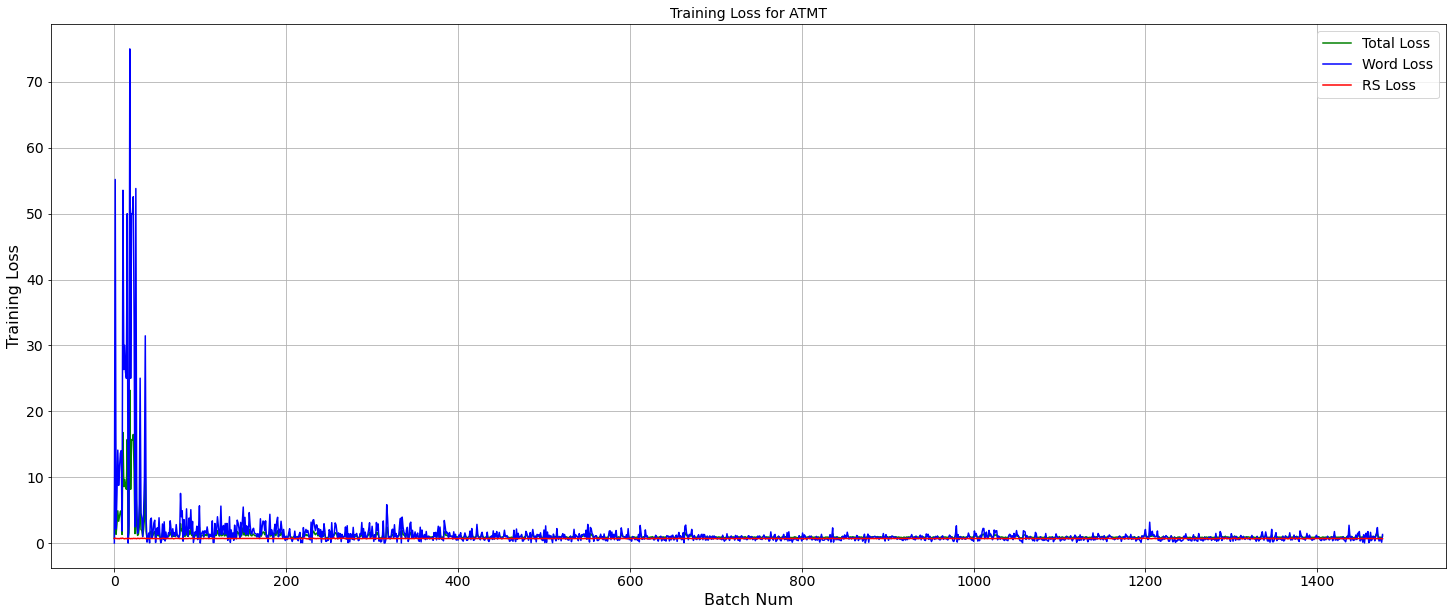

In [41]:
plot_epoch_loss(cp_train_losses[(26,30)])

In [80]:
for cp in test_score_maps.keys():
    df = test_score_maps[cp]
    df.to_csv("att_test_res/%s.csv"%str(cp),index=False)